**Описание данных:**

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

Остальное:
* `Churn` — факт оттока в текущем месяце.

**Оглавление:**
1. [Шаг 1. Изучение и предобработка данных](#step1)  
2. [Шаг 2. Исследовательский анализ данных (EDA)](#step2) 
3. [Шаг 3. Модель прогнозирования](#step3)
4. [Шаг 4. Кластеризация клиентов](#step4)
5. [Шаг 5. Общий вывод](#step5)

<a id="step1"></a>
## Шаг 1. Изучение и предобработка данных 

Для начала имортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

Прочитаем файл с данными:

In [2]:
df = pd.read_csv('datasets/gym_churn.csv')

Рассмотрим наш датасет:

In [3]:
display(df.head(10), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


None

В таблице имеются данные о 4000 пользователей, данные типа `int` и `float`, пропуски отсутствуют. В 7 столбцах данные представлены в бинарном виде (принимают значение 0 или 1).
Названия столбцов не соответствуют snake_case.
Столбец `Month_to_end_contract` содержит целочисленные значения, поэтому его можно преобразовать к типу `int`.

Приведем названия колонок к нижнему регистру:

In [4]:
df.columns = df.columns.str.lower()

Проверим наличие дубликатов:

In [5]:
df.duplicated().sum()

0

Дубликатов не обнаружено.

В столбце `month_to_end_contract` приведем данные к типу `int`:

In [6]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

**Вывод**

В нашем распоряжении таблица, состоящая из 40 000 строк и 18 столбцов, в которой содежатся данные клиента за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента, а также факт оттока клиентов.

В таблице имеются столбцы типа int и object. В 7 столбцах данные представлены в бинарном виде (принимают значение 0 или 1).

В ходе предобработки мы:

* установили, что в таблице отсутствуют пропущенные данные;
* привели названия столбцов к "змеиному" регистру;
* проверили, что в нашей таблице не содератся дубликаты;
* привели данные в столбце `month_to_end_contract` к типу int.


<a id="step2"></a>
## Шаг 2. Исследовательский анализ данных (EDA)

Посмотрим, как распределены данные в нашей таблице:

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


* `gender` — мужчин и женщин в наших данных примерно поровну.
* `near_location` — большинство клиентов (почти 85%) живут или работаю рядом с финтес-центром.
* `partner` — почти половина клиентов является сотрудниками компаний-партнёров клуба.
* `promo_friends` — около 30% клиентов были привлечены в рамках акции "приведи друга".
* `phone` — у 90% клиентов известны контантые мобильные телефоны.
* `contract_period` — средний период контракта 4.7 месяца, как минимум у 50% клиентов он составляет 1 месяц.
* `group_visits` — около 40% клиентов посещают групповые занятия.
* `age` — средний возраст клиентов составляет 29 лет, возрастной диапазон в таблице от 18 лет до 41 года.
* `avg_additional_charges_total` — средняя выручка с клиента за дополнительные услуги — 146 д.е.
* `month_to_end_contract` — среднее время до окончания контракта составляет 4.3 месяца, как минимум у 50% клиентов он составляет 1 месяц.
* `lifetime` — среднее время с момента первого обращения в фитнес-центр — 3.7 месяца, минимальный срок составляет 0 месяцев, максимальный — 31 месяц.
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента составляет 1.9 раз, минимум 0 раз, максимум 6 раз.
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц составляет 1.8 раз, минимум 0 раз, максимум 6.1 раз.
* `churn` — в текущем месяце 27% клиентов перестало пользоваться услугами фитнес-клуба (видим дисбаланс классов в целевом признаке, что важно в будущем для обучения модели).

Рассмотрим подробнее средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [8]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


* `gender` — данные по полу не отличаются.
* `near_location` — клиенты чаще остаются, когда живут или работаю рядом с финтес-центром.
* `partner` — сотрудники компаний-партнёров клуба чаще остаются.
* `promo_friends` — среди тех, кто был привлечен в рамках акции "приведи друга", уходящих в отток клиентов в два раза меньше.
* `phone` — по наличию контактного номера телефона данные не отличаются.
* `contract_period` — средняя длительность договора значительно больше у оставшихся пользователей (5.7 месяца), у клиентов в оттоке срок договора составляет 1.7 месяцев.
* `group_visits` — оставшиеся пользователи почти в 2 раза чаще ходят на групповые занятия.
* `age` — средний возраст оставшихся клиентов составляет 30 лет, клиентов в оттоке — 27 лет.
* `avg_additional_charges_total` — оставшиеся клиенты в среднем платят чуть больше за дополнительные услуги.
* `month_to_end_contract` — среднее время до окончания контракта значительно больше у оставшихся пользователей (5.2 месяца), у клиентов в оттоке среднее время до окончания контракта составляет 1.7 месяцев.
* `lifetime` — среднее время с момента первого обращения в фитнес-центр также значительно больше у оставшихся пользователей (4.7 месяца), у клиентов в оттоке среднее время с момента первого обращения составляет 1 месяц.
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента чуть больше у оставшихся клиентов.
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц у оставшихся клиентов в 2 раза больше, чем у клиентов оттоке.

Построим столбчатые гистограммы и распределения признаков для обеих групп:

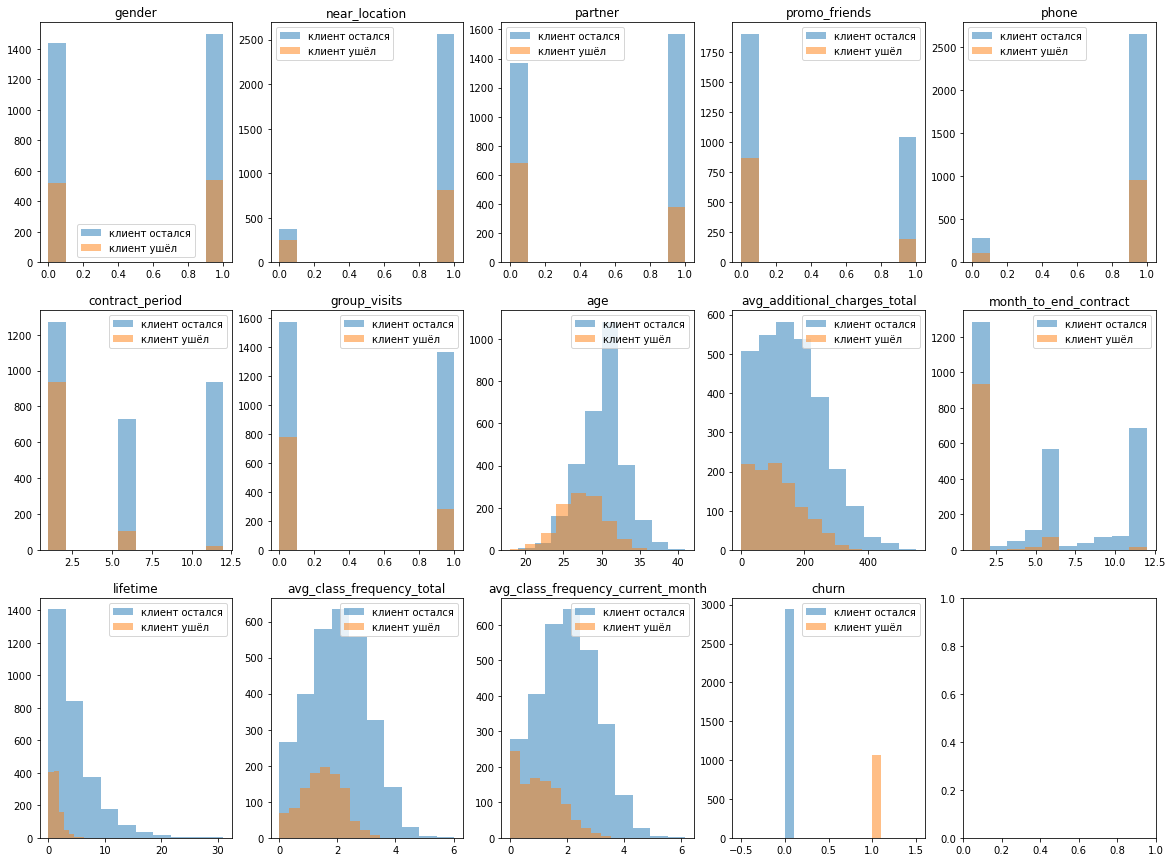

In [9]:
fig, axs = plt.subplots(3, 5, figsize=(20,15))
axs = axs.ravel()

try:
    for idx, ax in enumerate(axs):
        ax.hist(df.query('churn == 0').iloc[:, idx], label="клиент остался", alpha=0.5)
        ax.hist(df.query('churn == 1').iloc[:, idx], label="клиент ушёл", alpha=0.5)
        ax.set_title(df.columns[idx])
        ax.legend()
    plt.tight_layout()
except IndexError: 
    pass # игнорируем ошибку последнего незаполненного графика, т.к всего у нас 14 параметров

Видим, что в столбцах, где имеются неприрывные значения, явных выбросов не наблюдается, распределения выглядят более-менее нормально.

Самая популярная длительность контракта для обеих групп - 1 месяц. Наименее популярна среди оставшихся длительность 6 месяцев, для ушедших клиентов - 12 месяцев. Соответственно, схожую картину имеем в показателе среднего времени до окончания контракта.

Возрастное распределение для ушедших клиентов чуть смещено влево по сравнению с оставшимися клиентами, т.е. среди оставшихся в среднем чуть более взрослые клиенты.

Распределение трат на дополнительные услуги смещено влево, особенно для ушедших клиентов, т.е. люди в принципе склонны минимально пользоваться дополнительными услугами, в особенности это касается ушедших клиентов. 

Распределение времени с момента первого обращения имеет пик в минимальных значениях, т.е. наибольшая доля клиентов в обеих группах имеет очень небольшой "срок жизни".

Значения средней частоты посещений в неделю за все время с начала действия абонемента для обеих групп распределены нормально. Для группы оставшихся клиентов оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Схожую картину распределения имеем для средней частоты посещений в неделю за месяц.

Построим матрицу корреляций:

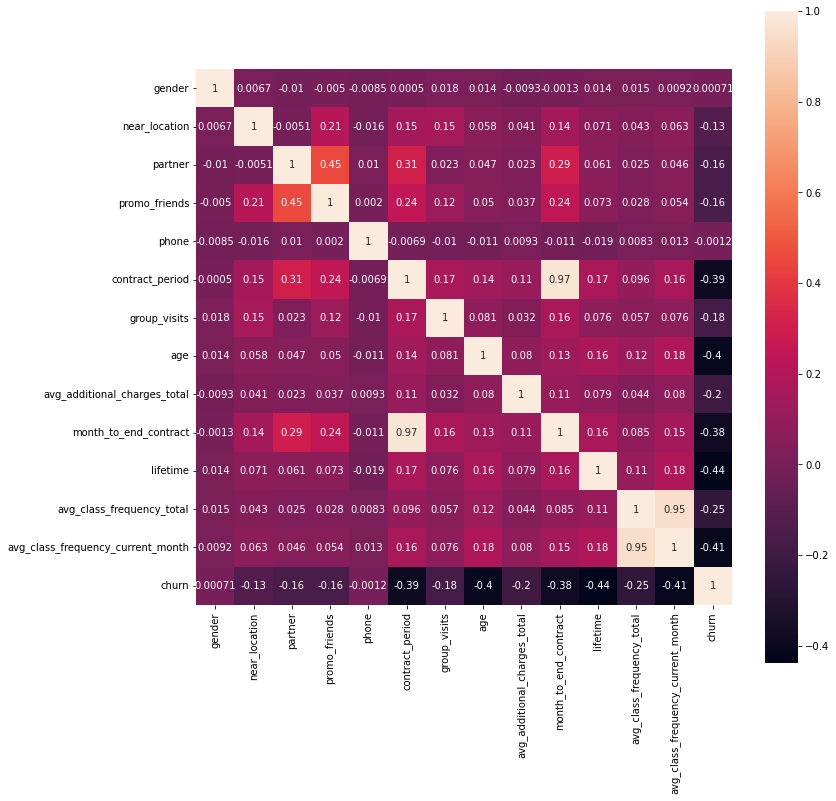

In [10]:
fig = plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True);

С целевой переменной `churn` значительной корреляции не наблюдается. 

Сильно коррелируют между собой `avg_class_frequency_total` и `avg_class_frequency_current_month`, а также `contract_period` и `month_to_end_contract`.

Методом подбора мы определили, что наилучшие показатели метрик наши модели имеют при удалении столбца `contract_period`:

In [11]:
df.drop('contract_period', axis = 1, inplace = True)

**Вывод**

1. Мы рассмотрели подробно признаки и целевую переменную и выяснили следующее:

* `gender` — мужчин и женщин в наших данных примерно поровну, по оттоку данные не отличаются.
* `near_location` — большинство клиентов (почти 85%) живут или работаю рядом с финтес-центром. Чаще остаются клиенты, которые живут или работаю рядом с финтес-центром.
* `partner` — почти половина клиентов является сотрудниками компаний-партнёров клуба, они же чаще остаются.
* `promo_friends` — около 30% клиентов были привлечены в рамках акции "приведи друга". Среди тех, кто был привлечен в рамках акции "приведи друга", уходящих в отток клиентов в два раза меньше.
* `phone` — у 90% клиентов известны контантые мобильные телефоны, данные для обеих групп не отличаются.
* `contract_period` — средний период контракта 4.7 месяца, как минимум у 50% клиентов он составляет 1 месяц. Показатель значительно больше у оставшихся пользователей (5.7 месяца), у клиентов в оттоке срок договора составляет 1.7 месяцев. Самая пополуряная длительность контракта для обеих групп - 1 месяц. Наименее популярна среди оставшихся длительность 6 месяцев, для ушедших клиентов - 12 месяцев.
* `group_visits` — около 40% клиентов посещают групповые занятия, оставшиеся пользователи почти в 2 раза чаще ходят на групповые занятия.
* `age` — средний возраст клиентов составляет 29 лет, возрастной диапазон в таблице от 18 лет до 41 года. Средний возраст оставшихся клиентов составляет 30 лет, клиентов в оттоке — 27 лет. Возрастное распределение для ушедших клиентов чуть смещено влево по сравнению с оставшимися клиентами, т.е. среди оставшихся в среднем чуть более взрослые клиенты.
* `avg_additional_charges_total` — средняя выручка с клиента за дополнительные услуги — 146 д.е., оставшиеся клиенты в среднем платят чуть больше за дополнительные услуги. Распределение трат на дополнительные услуги смещено влево, особенно для ушедших клиентов, т.е. люди в принципе склонны минимально пользоваться дополнительными услугами, в особенности это касается ушедших клиентов. 
* `month_to_end_contract` — среднее время до окончания контракта составляет 4.3 месяца, как минимум у 50% клиентов он составляет 1 месяц. Показатель больше у оставшихся пользователей (5.2 месяца), у клиентов в оттоке среднее время до окончания контракта составляет 1.7 месяцев.
* `lifetime` — среднее время с момента первого обращения в фитнес-центр — 3.7 месяца, минимальный срок составляет 0 месяцев, максимальный — 31 месяц. Показатель значительно больше у оставшихся пользователей (4.7 месяца), у клиентов в оттоке среднее время с момента первого обращения составляет 1 месяц. Распределение времени с момента первого обращения имеет пик в минимальных значениях, т.е. наибольшая доля клиентов в обеих группах имеет очень небольшой "срок жизни".
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента составляет 1.9 раз, минимум 0 раз, максимум 6 раз, показатель чуть больше у оставшихся клиентов. Значения средней частоты посещений в неделю за все время с начала действия абонемента для обеих групп распределены нормально. Для группы оставшихся клиентов оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево.
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц составляет 1.8 раз, минимум 0 раз, максимум 6.1 раз, у оставшихся клиентов показатель в 2 раза больше, чем у клиентов оттоке. Значения средней частоты посещений  в неделю за предыдущий месяц для обеих групп распределены нормально. Для группы оставшихся клиентов оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево.
* `churn` — в текущем месяце 27% клиентов перестало пользоваться услугами фитнес-клуба.

2. Мы построили матрицу корреляций и выяснили, что с целевой переменной `churn` значительной корреляции не наблюдается. Сильно коррелируют между собой признаки `avg_class_frequency_total` и `avg_class_frequency_current_month`, а также `contract_period` и `month_to_end_contract`. Чтобы избавиться от мультиколлинеарности, мы удалили признак `contract_period`.

<a id="step3"></a>
## Шаг 3. Модель прогнозирования оттока клиентов

Разделим выборку на обучащую и валидационную в пропорции 80:20.

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Стандартизируем данные:

In [13]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

Построим модель и обучим её алгоритмом логистической регрессии `LogisticRegression`:

In [14]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

### Случайный лес

Построим модель и обучим её алгоритмом случайного леса `RandomForestClassifier`:

In [15]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### Оценка метрик и сравнение моделей

Напишем функцию `print_all_metrics` для расчёта метрик:
* accuracy — доля правильных ответов,
* precision — точность,
* recall — полнота,
* F1_score — сводная метрика,
* ROC_AUC — метрика оценки качества классификатора.

In [16]:
def print_all_metrics(y_true, y_pred, y_proba, model):
    print('Метрики для модели {}:'.format(model))
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

Рассчитаем метрики для модели логистической регрессии и случайного леса:

In [17]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, 'логистической регрессии')
print()
print_all_metrics(y_test, rf_predictions, rf_probabilities, 'случайного леса')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.86
	F1: 0.88
	ROC_AUC: 0.98

Метрики для модели случайного леса:
	Accuracy: 0.93
	Precision: 0.90
	Recall: 0.83
	F1: 0.86
	ROC_AUC: 0.97


Более простая модель логистической регрессии в данном случай работает лучше, с помощью неё мы правильно прогнозируем 93% ответов. Доля правильных ответов (accuracy), точность (precision), полнота (recall), сводная метрика F1 у модели логистической регрессии выше, чем у модели случайного леса.

**Вывод**

Мы разделили выборку на обучащую и валидационную в соотношении 80:20 и провели стандартизацию данных.

Нами были построены и обучены модели алгоритмом логистической регрессии и алгоритмом случайного леса.

Обе модели показывают достаточное хорошие результаты прогноза. Но практически по всем метрикам, за исключением метрики оценки качества классификатора ROC_AUC (она у обеих моделей одинаковая), модель логистической регрессии подходит больше, чем модель случайного леса.

<a id="step4"></a>
## Шаг 4. Кластеризация клиентов

Выполним стандартизацию и передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage(). Чтобы диаграмма получилась показательной, передадим параметру method значение 'ward':

In [18]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

Построим дендрограмму:

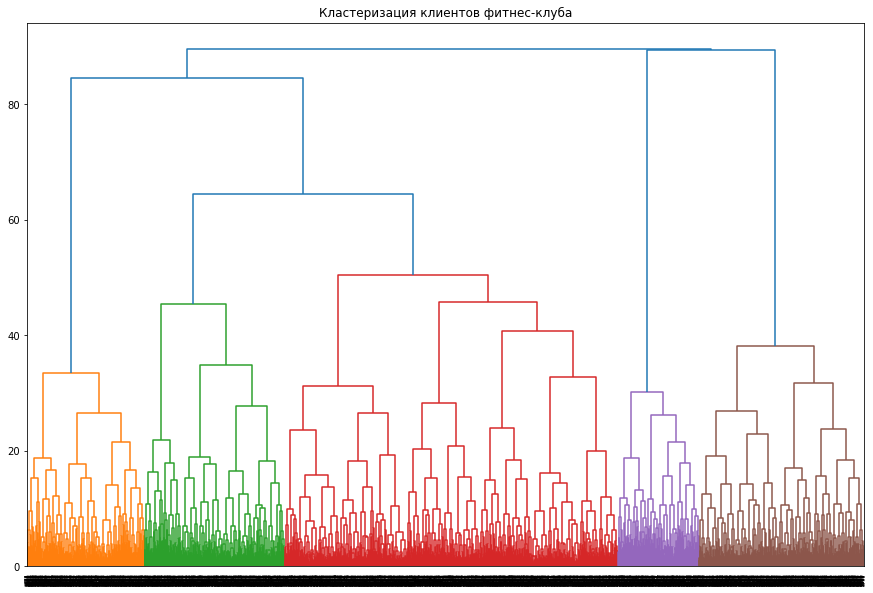

In [19]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-клуба')
plt.show() 

Исходя из дендрограммы мы можем выделить в данных пять кластеров.

Обучим модель кластеризации на основании алгоритма K-Means (задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата) и спрогнозируем кластеры клиентов.

In [20]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
df['cluster_km'] = labels
df['cluster_km'] = df['cluster_km'] + 1

Посмотрим на средние значения признаков для кластеров:

In [21]:
df.groupby('cluster_km').mean().T

cluster_km,1,2,3,4,5
gender,0.485597,0.524675,0.560428,0.493186,0.494382
near_location,0.992798,0.862338,0.973262,1.000000,0.000000
partner,0.940329,0.472727,0.309091,0.257240,0.486891
promo_friends,0.912551,0.306494,0.083422,0.094549,0.074906
phone,1.000000,0.000000,0.998930,1.000000,1.000000
group_visits,0.536008,0.425974,0.485561,0.330494,0.228464
age,29.612140,29.283117,30.270588,28.210392,28.573034
avg_additional_charges_total,154.221687,144.240418,165.107405,132.180078,136.299693
month_to_end_contract,7.080247,4.457143,4.655615,2.480409,2.674157
lifetime,4.432099,3.922078,4.989305,2.437819,2.910112


По некоторым признакам (например, `partner`, `promo_friends	`, `group_visits` и т.д.) видим достаточно явное деление на разные группы. Посмотрим на эти признаки более подробно на графиках распределения признаков для кластеров.

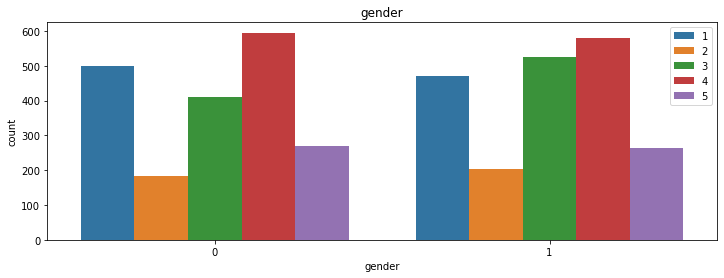

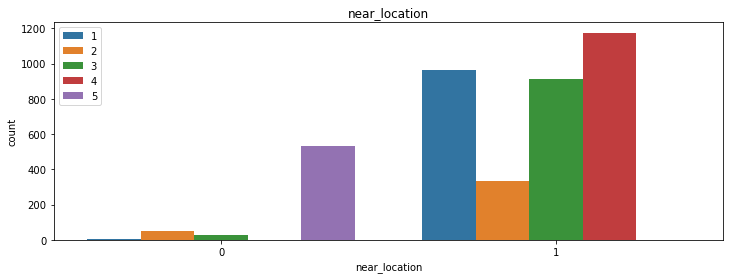

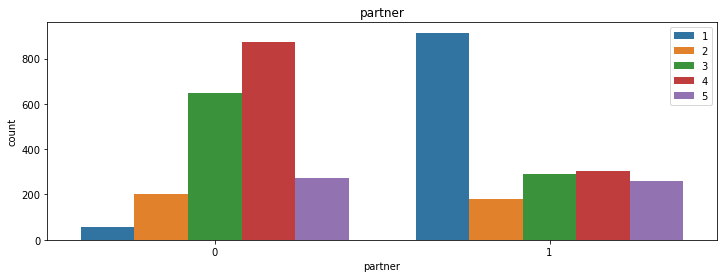

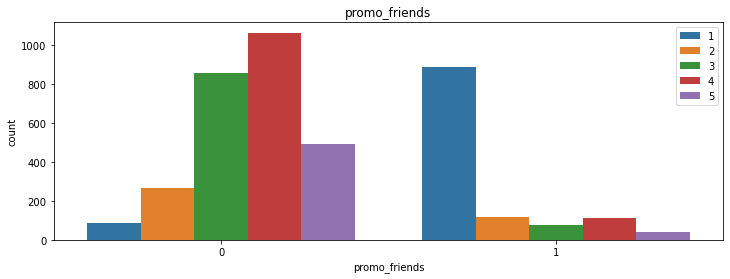

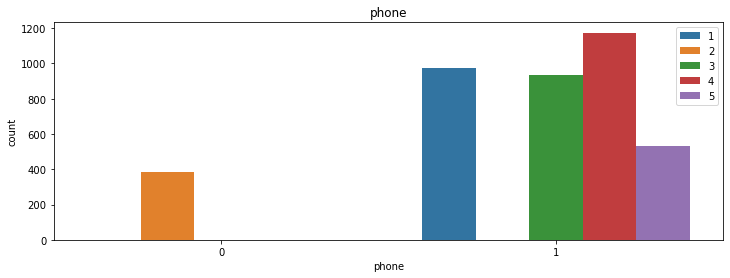

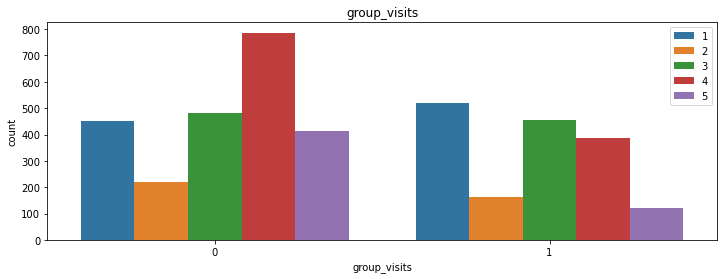

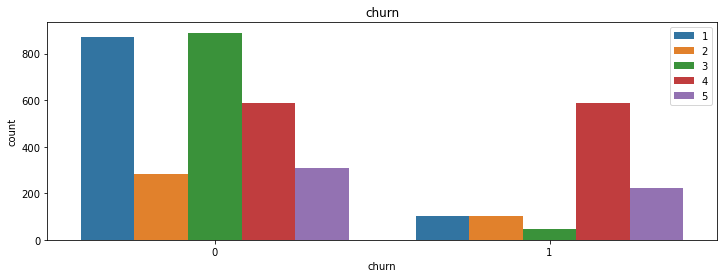

In [22]:
categorical_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x=df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.legend()
    plt.show()

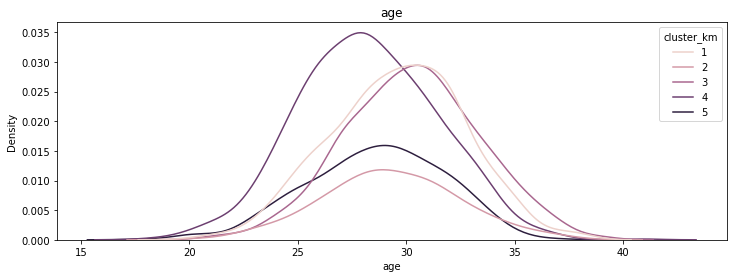

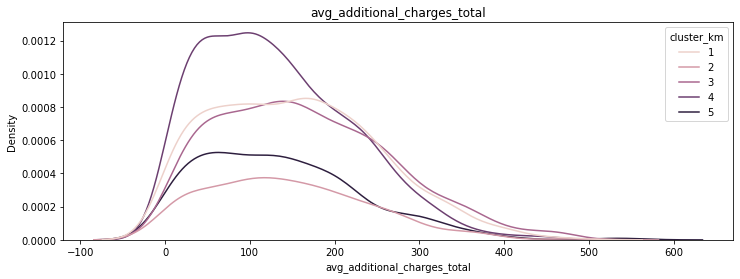

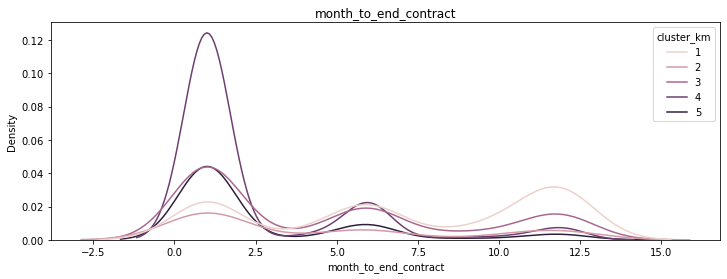

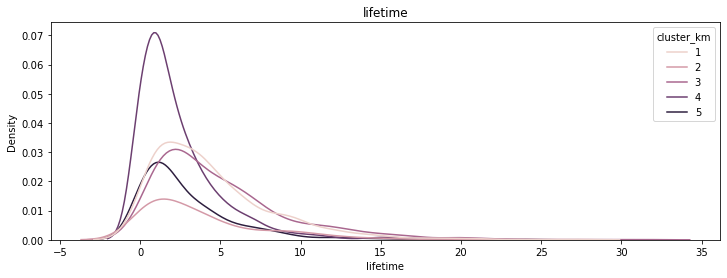

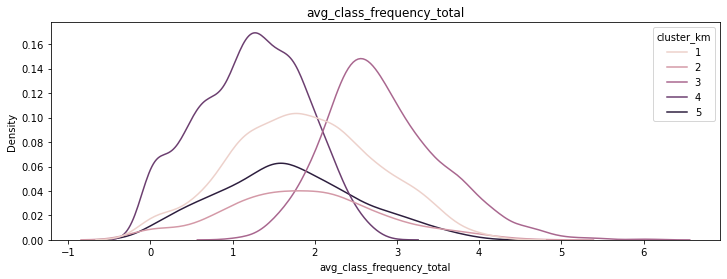

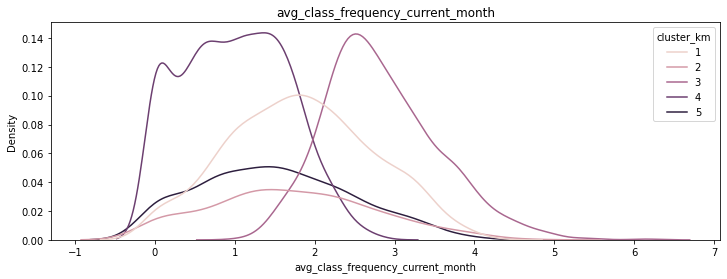

In [23]:
non_categorical_columns = ['age',
                           'avg_additional_charges_total',
                           'month_to_end_contract', 'lifetime',
                           'avg_class_frequency_total',
                           'avg_class_frequency_current_month'
                          ]

for column in non_categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.kdeplot(x=df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.show()

**Кластер 1**

* Равно распределены мужчины и женщины.
* Живут/работают недалеко от фитнес-клуба.
* *Больше пришло от компаний партнеров.*
* *Пришли по промо-акции от друзей.*
* Есть контактный номер телефона.
* Поровну ходят/не ходят на групповые занятия.
* Средний возраст 29.5 лет.
* На дополнительные услуги тратят в среднем 154 д.е.
* *Количество месяцев до окончания абонемента — преобладает 12 (больше всех).*
* Средний срок от начала пользования — 4.5 месяца.
* Среднее количество посещений всего/за месяц — 1.8.
* Преобладают оставшиеся пользователи.

**Кластер 2**

* Равно распределены мужчины и женщины.
* Живут/работают недалеко от фитнес-клуба.
* Поровну обычных клиентов и пришедших от компаний-партнёров.
* Пришли не по промо-акции.
* *Нет контактного номера телефона.*
* Примерно поровну ходят/не ходят на групповые занятия.
* Средний возраст 29 лет.
* На дополнительные услуги тратят в среднем 144 д.е.
* Количество месяцев до окончания абонемента — преобладает 1.
* Средний срок от начала пользования — 4 месяца.
* Среднее количество посещений всего/за месяц — 1.8/1.7.
* Преобладают оставшиеся пользователи.

**Кластер 3**

* *Не равно распределены мужчины и женщины (кого-то больше).*
* Живут/работают недалеко от фитнес-клуба.
* *Больше обычных клиентов, чем от компаний-партнёров.*
* Пришли не по промо-акции.
* Есть контактный номер телефона.
* Поровну ходят/не ходят на групповые занятия.
* *Средний возраст 30 лет (взрослее всех).*
* *На дополнительные услуги тратят в среднем 165 д.е.(больше всех).*
* Количество месяцев до окончания абонемента — преобладает 1.
* *Средний срок от начала пользования — 5 месяцев (больше всех).*
* *Среднее количество посещений всего/за месяц — 2.8 (больше всех).*
* Преобладают оставшиеся пользователи. 

**Кластер 4**

* Равно распределены мужчины и женщины.
* Живут/работают недалеко от фитнес-клуба.
* *Больше обычных клиентов, чем от компаний-партнёров.*
* Пришли не по промо-акции.
* Есть контактный номер телефона.
* *Больше не ходят на групповые.*
* *Средний возраст 28 лет (моложе всех).*
* *На дополнительные услуги тратят в среднем 132 д.е. (меньше всех).*
* Количество месяцев до окончания абонемента — преобладает 1.
* *Средний срок от начала пользования — 2.5 месяца (меньше всех).*
* *Среднее количество посещений всего/за месяц — 1.2/1 (меньше всех).*
* *Поровну оставшихся и ушедших.*

**Кластер 5**

* Равно распределены мужчины и женщины.
* *Живут/работают в отдалении от фитнес-клуба.*
* Поровну обычных клиентов и пришедших от компаний-партнёров.
* Пришли не по промо-акции.
* Есть контактный номер телефона.
* *Больше не ходят на групповые.*
* Средний возраст 28.5 лет.
* На дополнительные услуги тратят в среднем 136 д.е.
* Количество месяцев до окончания абонемента — преобладает 1.
* Средний срок от начала пользования — 3 месяца.
* Среднее количество посещений всего/за месяц — 1.5.
* Чуть больше оставшихся.

Посчитаем долю оттока для каждого полученного кластера:

In [24]:
df.groupby('cluster_km').agg({'churn':'mean'}).sort_values(by='churn', ascending=False)

,churn
cluster_km,
4,0.500852
5,0.419476
2,0.267532
1,0.103909
3,0.048128


Четверый кластер больше всего склонен к оттоку: доля ушедших клиентов составляет 50%. Пятый кластер характеризуется долей оттока 42%, а второй - около 27%. Первый и третий кластеры (доля оттока 10% и 5% соответственно) являются самыми надёжными.

**Вывод**

Мы стандартизировали данные, построили матрицу расстояний и дендрограмма. Исходя из дендрограммы мы смогли выделить в данных пять кластеров, которые мы использовали для обучения модель кластеризации на основании алгоритма K-Means.


Проанализировав средние значения и распределения признаков для кластеров мы отметили следующие явные характеристики кластеров:

**Кластер 1**

* Больше клиентов пришло от компаний партнеров.
* Пришли по промо-акции от друзей.
* Количество месяцев до окончания абонемента — преобладает 12 (больше всех).
* Доля оттока составляет 10%.

**Кластер 2**

* Нет контактного номера телефона.
* Количество месяцев до окончания абонемента — преобладает 1.
* Доля оттока составляет 27%.

**Кластер 3**

* Не равно распределены мужчины и женщины (кого-то больше).
* Больше обычных клиентов, чем от компаний-партнёров.
* Средний возраст 30 лет (взрослее всех).
* На дополнительные услуги тратят в среднем 165 д.е.(больше всех).
* Средний срок от начала пользования — 5 месяцев (больше всех).
* Среднее количество посещений всего/за месяц — 2.8 (больше всех).
* Доля оттока составляет 5%. 

**Кластер 4**

* Больше обычных клиентов, чем от компаний-партнёров.
* Больше не ходят на групповые.
* Средний возраст 28 лет (моложе всех).
* На дополнительные услуги тратят в среднем 132 д.е. (меньше всех).
* Средний срок от начала пользования — 2.5 месяца (меньше всех).
* Среднее количество посещений всего/за месяц — 1.2/1 (меньше всех).
* Доля оттока составляет 50%.

**Кластер 5**

* Живут/работают в отдалении от фитнес-клуба.
* Больше не ходят на групповые.
* Количество месяцев до окончания абонемента — преобладает 1.
* Доля оттока составляет 42%. 

Четверый кластер больше всего склонен к оттоку: доля ушедших клиентов составляет 50%. Пятый кластер характеризуется долей оттока 42%, а второй - около 27%. Первый и третий кластеры (доля оттока 10% и 5% соответственно) являются самыми надёжными.

<a id="step5"></a>
## Шаг 5. Общий вывод

Мы провели исследование оттока клентов для сети фитнес-центров. В нашем распоряжении была таблица, в которой содежатся данные клиента за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента, а также факт оттока клиентов.

Наше исследование состяло из нескольких этапов:

1. При общем анализе данных мы выяснили, что:

* `gender` — мужчин и женщин в наших данных примерно поровну.
* `near_location` — большинство клиентов (почти 85%) живут или работаю рядом с финтес-центром.
* `partner` — почти половина клиентов является сотрудниками компаний-партнёров клуба.
* `promo_friends` — около 30% клиентов были привлечены в рамках акции "приведи друга".
* `phone` — у 90% клиентов известны контантые мобильные телефоны.
* `contract_period` — средний период контракта 4.7 месяца, как минимум у 50% клиентов он составляет 1 месяц.
* `group_visits` — около 40% клиентов посещают групповые занятия.
* `age` — средний возраст клиентов составляет 29 лет, возрастной диапазон в таблице от 18 лет до 41 года.
* `avg_additional_charges_total` — средняя выручка с клиента за дополнительные услуги — 146 д.е.
* `month_to_end_contract` — среднее время до окончания контракта составляет 4.3 месяца, как минимум у 50% клиентов он составляет 1 месяц.
* `lifetime` — среднее время с момента первого обращения в фитнес-центр — 3.7 месяца, минимальный срок составляет 0 месяцев, максимальный — 31 месяц.
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента составляет 1.9 раз, минимум 0 раз, максимум 6 раз.
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц составляет 1.8 раз, минимум 0 раз, максимум 6.1 раз.
* `churn` — в текущем месяце 27% клиентов перестало пользоваться услугами фитнес-клуба.

2. В результате исследования средних значений в двух группах — тех, кто ушел в отток и тех, кто остался, мы выяснили следущее:

* `gender` — данные по полу не отличаются.
* `near_location` — клиенты чаще остаются, когда живут или работаю рядом с финтес-центром.
* `partner` — сотрудники компаний-партнёров клуба чаще остаются.
* `promo_friends` — среди тех, кто был привлечен в рамках акции "приведи друга", уходящих в отток клиентов в два раза меньше.
* `phone` — по наличию контактного номера телефона данные не отличаются.
* `contract_period` — средняя длительность договора значительно больше у оставшихся пользователей (5.7 месяца), у клиентов в оттоке срок договора составляет 1.7 месяцев.
* `group_visits` — оставшиеся пользователи почти в 2 раза чаще ходят на групповые занятия.
* `age` — средний возраст оставшихся клиентов составляет 30 лет, клиентов в оттоке — 27 лет.
* `avg_additional_charges_total` — оставшиеся клиенты в среднем платят чуть больше за дополнительные услуги.
* `month_to_end_contract` — среднее время до окончания контракта значительно больше у оставшихся пользователей (5.2 месяца), у клиентов в оттоке среднее время до окончания контракта составляет 1.7 месяцев.
* `lifetime` — среднее время с момента первого обращения в фитнес-центр также значительно больше у оставшихся пользователей (4.7 месяца), у клиентов в оттоке среднее время с момента первого обращения составляет 1 месяц.
* `avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента чуть больше у оставшихся клиентов.
* `avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц у оставшихся клиентов в 2 раза больше, чем у клиентов оттоке.

3. В результате построения гистограмм и распределений мы установили, что:

* В столбцах, где имеются неприрывные значения, явных выбросов не наблюдается, распределения выглядят более-менее нормально.
* Самая популярная длительность контракта для обеих групп - 1 месяц. Наименее популярна среди оставшихся длительность 6 месяцев, для ушедших клиентов - 12 месяцев. Соответственно, схожую картину имеем в показателе среднего времени до окончания контракта.
* Возрастное распределение для ушедших клиентов чуть смещено влево по сравнению с оставшимися клиентами, т.е. среди оставшихся в среднем чуть более взрослые клиенты.
* Распределение трат на дополнительные услуги смещено влево, особенно для ушедших клиентов, т.е. люди в принципе склонны минимально пользоваться дополнительными услугами, в особенности это касается ушедших клиентов.
* Распределение времени с момента первого обращения имеет пик в минимальных значениях, т.е. наибольшая доля клиентов в обеих группах имеет очень небольшой "срок жизни".
* Значения средней частоты посещений в неделю за все время с начала действия абонемента для обеих групп распределены нормально. Для группы оставшихся клиентов оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Схожую картину распределения имеем для средней частоты посещений в неделю за месяц.

4. По результатам построения матрицы корреляций мы приняли решение об удалении признака contract_period с целью избавления от мультиколлениарности. 

5. Мы разделили выборку на обучащую и валидационную в соотношении 80:20 и провели стандартизацию данных. Нами были построены и обучены модели алгоритмом логистической регрессии и алгоритмом случайного леса. Обе модели показывают достаточное хорошие результаты прогноза. Но практически по всем метрикам, за исключением метрики оценки качества классификатора ROC_AUC (она у обеих моделей одинаковая), модель логистической регрессии подходит больше, чем модель случайного леса.

6. Мы стандартизировали данные, построили матрицу расстояний и дендрограмма. Исходя из дендрограммы мы смогли выделить в данных пять кластеров, которые мы использовали для обучения модель кластеризации на основании алгоритма K-Means.

Проанализировав средние значения и распределения признаков для кластеров мы отметили следующие явные характеристики кластеров:

**Кластер 1**

* Больше клиентов пришло от компаний партнеров.
* Пришли по промо-акции от друзей.
* Количество месяцев до окончания абонемента — преобладает 12 (больше всех).
* Доля оттока составляет 10%.

**Кластер 2**

* Нет контактного номера телефона.
* Количество месяцев до окончания абонемента — преобладает 1.
* Доля оттока составляет 27%.

**Кластер 3**

* Не равно распределены мужчины и женщины (кого-то больше).
* Больше обычных клиентов, чем от компаний-партнёров.
* Средний возраст 30 лет (взрослее всех).
* На дополнительные услуги тратят в среднем 165 д.е.(больше всех).
* Средний срок от начала пользования — 5 месяцев (больше всех).
* Среднее количество посещений всего/за месяц — 2.8 (больше всех).
* Доля оттока составляет 5%. 

**Кластер 4**

* Больше обычных клиентов, чем от компаний-партнёров.
* Больше не ходят на групповые.
* Средний возраст 28 лет (моложе всех).
* На дополнительные услуги тратят в среднем 132 д.е. (меньше всех).
* Средний срок от начала пользования — 2.5 месяца (меньше всех).
* Среднее количество посещений всего/за месяц — 1.2/1 (меньше всех).
* Доля оттока составляет 50%.

**Кластер 5**

* Живут/работают в отдалении от фитнес-клуба.
* Больше не ходят на групповые.
* Количество месяцев до окончания абонемента — преобладает 1.
* Доля оттока составляет 42%. 

Четверый кластер больше всего склонен к оттоку: доля ушедших клиентов составляет 50%. Пятый кластер характеризуется долей оттока 42%, а второй - около 27%. Первый и третий кластеры (доля оттока 10% и 5% соответственно) являются самыми надёжными.

**Базовые рекомендации по работе с клиентами**

По полученным результатам можно предложить следующее рекомендации:

* Обратиться к маркетинговым мероприятиям, направленным на привлечение клиентов, проживающих или работающих рядом с фитнес-центрами (например, наружная реклама, реклама в магазинах/торговых центрах неподалёку и т.п.).

* Сделать более привлекательным/выгодным для клиентов приобретение долгосрочных абонементов (6, 12 месяцев), т.к. такие клиенты лучше удерживаются. 

* Продумать акционные предложения, связанные с посещением групповых занятий, поскольку клиенты этой категории реже уходят в отток.
